In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smiling-or-not-face-data/smile/Tubby_Smith_0003.jpg
/kaggle/input/smiling-or-not-face-data/smile/Rebecca_Romijn-Stamos_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Martin_Scorsese_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Pierre_Png_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Tom_Rouen_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Jason_Sehorn_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Jennifer_Rodriguez_0002.jpg
/kaggle/input/smiling-or-not-face-data/smile/Ray_Romano_0002.jpg
/kaggle/input/smiling-or-not-face-data/smile/King_Abdullah_II_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Peri_Gilpin_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Shingo_Suetsugu_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Jane_Walker_Wood_0001.jpg
/kaggle/input/smiling-or-not-face-data/smile/Joe_Nichols_0003.jpg
/kaggle/input/smiling-or-not-face-data/smile/Katie_Couric_0001.jpg
/kaggle/input/smiling-or-not-face-data/smil

In [2]:
import pandas as pd
import numpy as np
import os, shutil, math, cv2
from tqdm import tqdm
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
sdir = '/kaggle/input/smiling-or-not-face-data/'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(['smile', 'non_smile'])
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count


train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

smile                  : 100%|███████████████████████████████████████████| 600/600 [00:01<00:00, 396.00file/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  482   the minimum files in any class in train_df is  480
train_df length:  962   test_df length:  121   valid_df length:  120
average image height=  64   average image width=  64  aspect ratio h/w=  1.0


In [4]:
epochs = 30
batch_size = 16
img_size = (64, 64)
input_shape = (64, 64, 3)

In [5]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 962 validated image filenames belonging to 2 classes.            for train generator 
Found 120 validated image filenames belonging to 2 classes.            for valid generator 
Found 121 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  11 test steps:  11 number of classes :  2


In [6]:
class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, growth_rate, drop_rate):
        super(BottleNeck, self).__init__()
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.C1 = Conv2D(filters=4 * growth_rate, kernel_size=(1, 1), strides=1, padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.C2 = Conv2D(filters=growth_rate, kernel_size=(3, 3), strides=1, padding='same')
        self.Dr1 = Dropout(drop_rate)

    def call(self, inputs, training=None, **kwargs):
        x = self.B1(inputs, training=training)
        x = self.A1(x)
        x = self.C1(x)
        x = self.B2(x, training=training)
        x = self.A2(x)
        x = self.C2(x)
        y = self.Dr1(x, training=training)
        return y


class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, growth_rate, drop_rate):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.drop_rate = drop_rate
        self.features_list = []
        self.bottle_necks = []
        for i in range(self.num_layers):
            self.bottle_necks.append(
                BottleNeck(growth_rate=self.growth_rate, drop_rate=self.drop_rate)
            )

    def call(self, inputs, training=None, **kwargs):
        self.features_list.append(inputs)
        x = inputs
        for i in range(self.num_layers):
            y = self.bottle_necks[i](x, training=training)
            self.features_list.append(y)
            x = tf.concat(self.features_list, axis=-1)
        self.features_list.clear()
        return x


class TransitionLayer(tf.keras.layers.Layer):
    def __init__(self, out_channels):
        super(TransitionLayer, self).__init__()
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.C1 = Conv2D(filters=out_channels, kernel_size=(1, 1), strides=1, padding='same')
        self.P1 = MaxPooling2D(2, padding='same')

    def call(self, inputs, training=None, **kwargs):
        x = self.B1(inputs, training=training)
        x = self.A1(x)
        x = self.C1(x)
        y = self.P1(x)
        return y


class MyDenseNet(tf.keras.layers.Layer):
    def __init__(self, num_init_features, growth_rate, block_layers, compression_rate, drop_rate):
        super(MyDenseNet, self).__init__()
        self.C1 = Conv2D(filters=num_init_features, kernel_size=(7, 7), strides=2, padding="same", input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")

        self.num_channels = num_init_features
        self.dense_block_1 = DenseBlock(num_layers=block_layers[0], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[0]
        self.num_channels = compression_rate * self.num_channels
        self.transition_1 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_2 = DenseBlock(num_layers=block_layers[1], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[1]
        self.num_channels = compression_rate * self.num_channels
        self.transition_2 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_3 = DenseBlock(num_layers=block_layers[2], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[2]
        self.num_channels = compression_rate * self.num_channels
        self.transition_3 = TransitionLayer(out_channels=int(self.num_channels))
        self.dense_block_4 = DenseBlock(num_layers=block_layers[3], growth_rate=growth_rate, drop_rate=drop_rate)

        self.P2 = GlobalAveragePooling2D()

    def call(self, inputs, training=None, **kwargs):
        x = self.C1(inputs)
        x = self.B1(x, training=training)
        x = self.A1(x)
        x = self.P1(x)

        x = self.dense_block_1(x, training=training)
        x = self.transition_1(x, training=training)
        x = self.dense_block_2(x, training=training)
        x = self.transition_2(x, training=training)
        x = self.dense_block_3(x, training=training)
        x = self.transition_3(x, training=training)
        x = self.dense_block_4(x, training=training)

        y = self.P2(x)

        return y

In [7]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output



class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [8]:
class NeuralNetwork(tf.keras.Model):
    def __init__(self, initial_filters, block_list, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = MyDenseNet(num_init_features=64, growth_rate=32, block_layers=[6, 12, 48, 32], compression_rate=0.5, drop_rate=0.5)
        self.layer2 = ResMLP(initial_filters=initial_filters, block_list=block_list, num_classes=num_classes)
        
    def call(self, x):
        x = self.layer1(x)
        y = self.layer2(x)
        return y

In [9]:
net = NeuralNetwork(initial_filters=32, block_list=[2, 2], num_classes=2)

net.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'AUC'])

chechpoint_save_path = './MyNet.ckpt'
if os.path.exists(chechpoint_save_path + '.index'):
    net.load_weights(chechpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=chechpoint_save_path, save_best_only=True, save_weights_only=True)    

history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=valid_ds, callbacks=[cp_callback])

net.summary()

file = open('./Weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
    
file.close()

Epoch 1/30
61/61 [==============================] - 47s 253ms/step - loss: 0.7090 - accuracy: 0.5499 - auc: 0.5574 - val_loss: 0.7047 - val_accuracy: 0.5083 - val_auc: 0.5072
Epoch 2/30
61/61 [==============================] - 9s 151ms/step - loss: 0.6677 - accuracy: 0.5956 - auc: 0.6332 - val_loss: 0.6814 - val_accuracy: 0.5333 - val_auc: 0.5978
Epoch 3/30
61/61 [==============================] - 9s 150ms/step - loss: 0.6709 - accuracy: 0.6154 - auc: 0.6432 - val_loss: 0.6610 - val_accuracy: 0.5917 - val_auc: 0.6517
Epoch 4/30
61/61 [==============================] - 9s 151ms/step - loss: 0.6143 - accuracy: 0.6746 - auc: 0.7277 - val_loss: 0.6827 - val_accuracy: 0.5667 - val_auc: 0.6625
Epoch 5/30
61/61 [==============================] - 9s 149ms/step - loss: 0.5490 - accuracy: 0.7256 - auc: 0.7960 - val_loss: 1.1043 - val_accuracy: 0.5000 - val_auc: 0.6285
Epoch 6/30
61/61 [==============================] - 9s 148ms/step - loss: 0.4885 - accuracy: 0.7755 - auc: 0.8476 - val_loss: 1.1

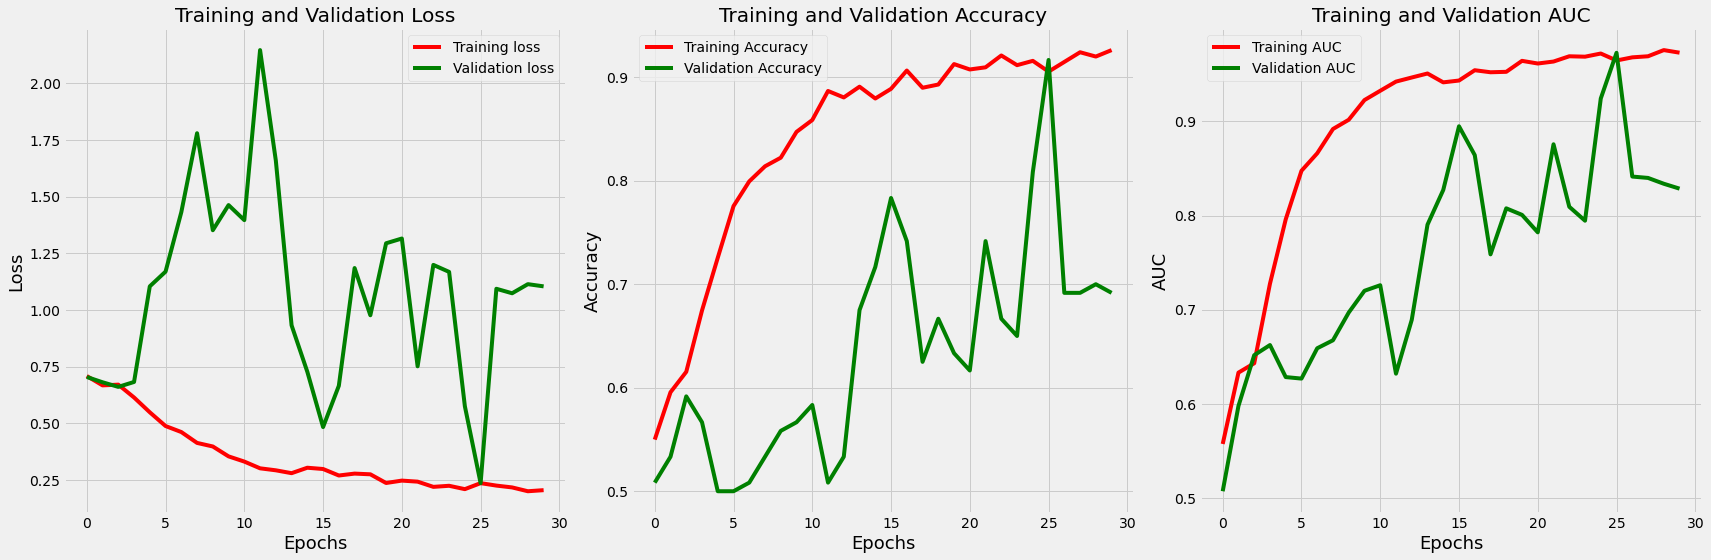

In [10]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(Epochs, tauc, 'r', label='Training AUC')
    axes[2].plot(Epochs, vauc, 'g', label='Validation AUC')
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs


Epochs = plot_auc_acc_loss(history, epochs)